In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm

%matplotlib inline

(cv2.__version__)

'4.1.2'

In [2]:
class Struct:
    def __init__(self, **kwds):
        self.__dict__.update(kwds)

Colors = Struct(
    white=(255.0, 255.0, 255.0),
    green=(0.0, 255.0, 0.0),
    red=(0.0, 0.0, 255.0),
    yellow=(255.0, 255.0, 0.0)
)

<hr>

## Load the image

In [358]:
filename = '../../Database/260220_high/1.jpg'

In [359]:
roi = (0,0)

In [360]:
imgOriginal = cv2.imread(filename)

In [361]:
resizingVec = (1600,1200)
height, width, _ = imgOriginal.shape
if (width < height):
    resizingVec = (1200,1600)
imgResized = cv2.resize(imgOriginal, resizingVec) 

In [362]:
def crop_roi_from_image(frame, roi):

    if len(roi) == 2 and roi[0] == 0 and roi[1] == 0:
        imgCropped = frame

    else:
        roiW = roi[2]

        if len(roi) == 4:
            roiH = roi[3]
        else:
            roiH = roi[2]

        roiCx = roi[0] + roiW / 2.0
        roiCy = roi[1] + roiH / 2.0

        imgCropped = cv2.getRectSubPix(frame, (roiW, roiH), (roiCx, roiCy))

    return imgCropped

In [363]:
imgCropped = crop_roi_from_image(imgResized, roi)

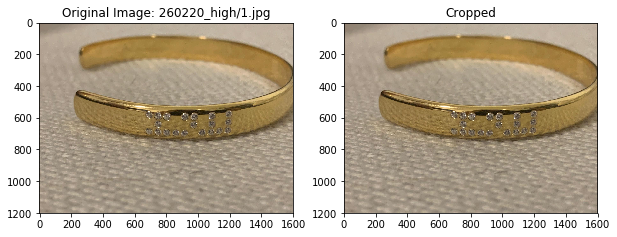

In [364]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(imgOriginal[...,::-1])
ax[1].imshow(imgCropped[...,::-1])
ax[0].set_title('Original Image: %s' % '/'.join(filename.split('/')[-2:]))
ax[1].set_title('Cropped')
plt.show()

<hr>

## Pre Processing

### Color-Space-Conversion (CSC)

In [353]:
imgHSV = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2HSV)
imgLAB = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2LAB)

H, S, V = cv2.split(imgHSV)
L, A, B = cv2.split(imgLAB)

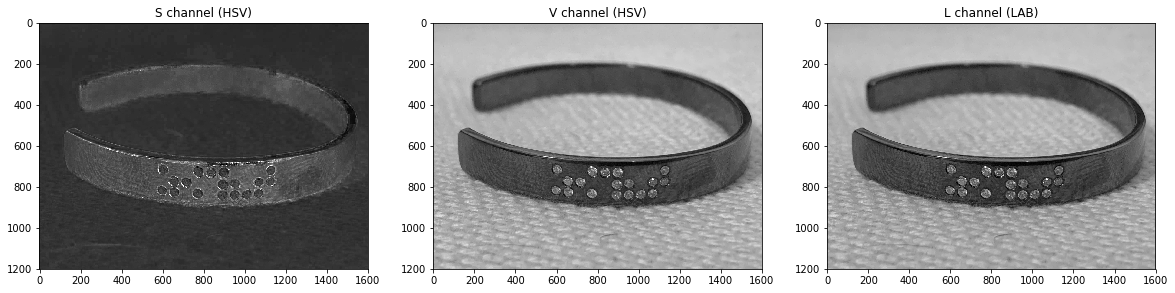

In [354]:
fig, ax = plt.subplots(1,3, figsize=(20,16))
ax[0].imshow(S, cmap=plt.get_cmap('gray'))
ax[1].imshow(V, cmap=plt.get_cmap('gray'))
ax[2].imshow(L, cmap=plt.get_cmap('gray'))
ax[0].set_title('S channel (HSV)')
ax[1].set_title('V channel (HSV)')
ax[2].set_title('L channel (LAB)')
plt.show()

### Increase contrast (morphological)

In [85]:
def maximizeContrast(imgGrayscale, PreprocessMorphKernel):
    """ Morphological filtering for increasing contrast: OutputImage = InputImage + TopHat - BlackHat """

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, PreprocessMorphKernel)

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)      # = Image - Opening[Image] = Image - dilate[erode[Image]] --> "lowFreq"
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)  # = Closing[Image] - Image = erode[dilate[Image]] - Image --> "highFreq"

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat

In [86]:
PreprocessMorphKernel = (3,3)
imgMaxContrastGrayscale_S = maximizeContrast(S, PreprocessMorphKernel)
imgMaxContrastGrayscale_V = maximizeContrast(V, PreprocessMorphKernel)
imgMaxContrastGrayscale_L = maximizeContrast(L, PreprocessMorphKernel)

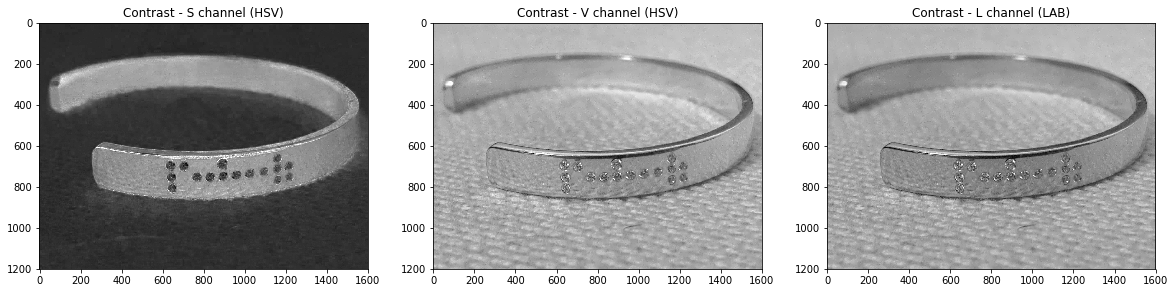

In [87]:
fig, ax = plt.subplots(1,3, figsize=(20,16))
ax[0].imshow(imgMaxContrastGrayscale_S, cmap='gray')
ax[1].imshow(imgMaxContrastGrayscale_V, cmap='gray')
ax[2].imshow(imgMaxContrastGrayscale_L, cmap='gray')
ax[0].set_title('Contrast - S channel (HSV)')
ax[1].set_title('Contrast - V channel (HSV)')
ax[2].set_title('Contrast - L channel (LAB)')
plt.show()

### Blurring

In [88]:
PreprocessGaussKernel=(3,3)
imgBlurred_S = cv2.GaussianBlur(imgMaxContrastGrayscale_S, PreprocessGaussKernel, 0)
imgBlurred_V = cv2.GaussianBlur(imgMaxContrastGrayscale_V, PreprocessGaussKernel, 0)
imgBlurred_L = cv2.GaussianBlur(imgMaxContrastGrayscale_L, PreprocessGaussKernel, 0)

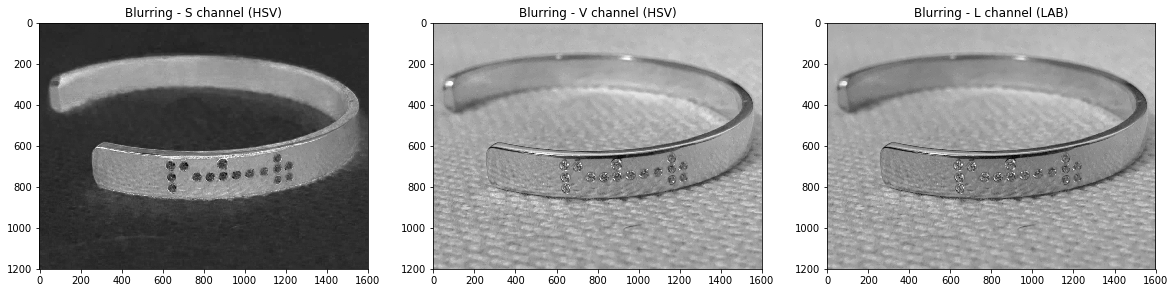

In [89]:
fig, ax = plt.subplots(1,3, figsize=(20,16))
ax[0].imshow(imgBlurred_S, cmap='gray')
ax[1].imshow(imgBlurred_V, cmap='gray')
ax[2].imshow(imgBlurred_L, cmap='gray')
ax[0].set_title('Blurring - S channel (HSV)')
ax[1].set_title('Blurring - V channel (HSV)')
ax[2].set_title('Blurring - L channel (LAB)')
plt.show()

### Adaptive Threshold

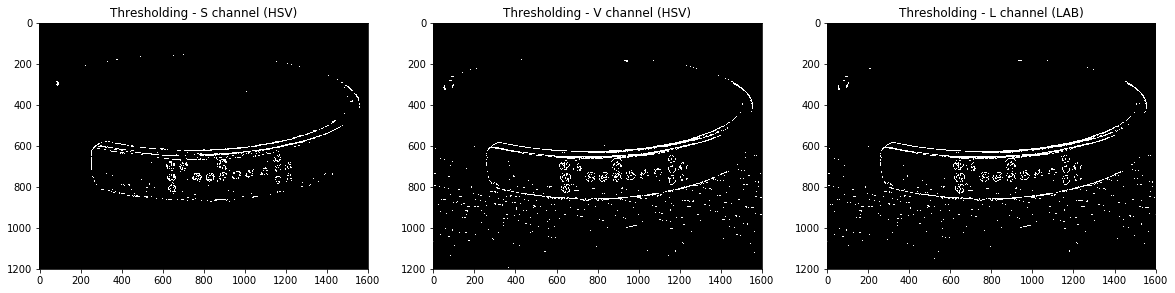

In [90]:
#PreprocessThreshweight, PreprocessThreshBlockSize = 7, 29
PreprocessThreshweight, PreprocessThreshBlockSize = 19, 43

imgThresh_S = cv2.adaptiveThreshold(imgBlurred_S, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, PreprocessThreshBlockSize, PreprocessThreshweight)
imgThresh_V = cv2.adaptiveThreshold(imgBlurred_V, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, PreprocessThreshBlockSize, PreprocessThreshweight)
imgThresh_L = cv2.adaptiveThreshold(imgBlurred_L, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, PreprocessThreshBlockSize, PreprocessThreshweight)

fig, ax = plt.subplots(1,3, figsize=(20,16))
ax[0].imshow(imgThresh_S, cmap='gray')
ax[1].imshow(imgThresh_V, cmap='gray')
ax[2].imshow(imgThresh_L, cmap='gray')
ax[0].set_title('Thresholding - S channel (HSV)')
ax[1].set_title('Thresholding - V channel (HSV)')
ax[2].set_title('Thresholding - L channel (LAB)')
plt.show()

From now on, sticking with a single channel:

In [91]:
frame_thresh_pre = imgThresh_V.copy()
height, width = frame_thresh_pre.shape

<hr>

## Morphological Closing

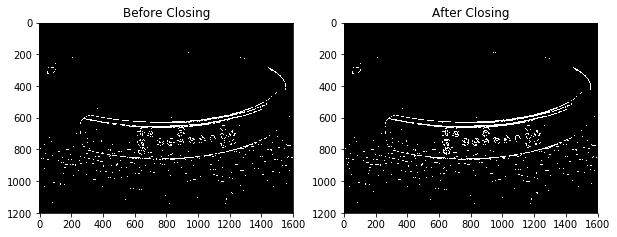

In [92]:
PreprocessClosingKernel, PreprocessClosingKernelMedianBlur = (5,5), 1
#PreprocessClosingKernel, PreprocessClosingKernelMedianBlur = (3,3), 5

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, PreprocessClosingKernel)
frame_thresh = cv2.morphologyEx(frame_thresh_pre, cv2.MORPH_CLOSE, structuringElement)
frame_thresh = cv2.medianBlur(frame_thresh,PreprocessClosingKernelMedianBlur)

fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(frame_thresh_pre, cmap='gray')
ax[1].imshow(frame_thresh, cmap='gray')
ax[0].set_title('Before Closing')
ax[1].set_title('After Closing')
plt.show()

<hr>

## Find Circles

In [93]:
frame_contours = np.zeros((height, width, 3), np.uint8)
frame_contours[:,:,0] = frame_thresh
frame_contours[:,:,1] = frame_thresh
frame_contours[:,:,2] = frame_thresh

circles = cv2.HoughCircles(image=frame_thresh,         # 8-bit, single channel image.
                           method=cv2.HOUGH_GRADIENT,  # Defines the method to detect circles in images
                           dp=1,                       # Large dp values -->  smaller accumulator array
                           minDist=60,#40,             # Minimum distance between the centers of detected circles
                           param1=50,                  # Gradient value used to handle edge detection
                           param2=18,                  # Accumulator threshold value (smaller = more circles)
                           minRadius=20,               # Minimum size of the radius (in pixels)
                           maxRadius=50)               # Maximum size of the radius (in pixels)

if False:

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(frame_contours, (i[0], i[1]), i[2], Colors.green, 3)

    plt.subplots(1,1, figsize=(10,8))
    plt.imshow(frame_contours)
    plt.show()

<hr>

## Circles to Contours

In [94]:
def circle_to_contour(circle, points_per_contour, resize_factor):

    xc, yc, r = circle
    r *= resize_factor
    contour = []
    for i in np.linspace(0, 2*np.pi, points_per_contour):
        y = int(yc + r * np.sin(i))
        x = int(xc + r * np.cos(i))
        contour.append([[x, y]])
    return np.array(contour)

In [95]:
contours = []
if circles is not None:
    for i in circles[0, :]:
        contours.append(circle_to_contour(i, 50, 0.7))

In [96]:
print('#Circles: %d' % len(contours))

#Circles: 1


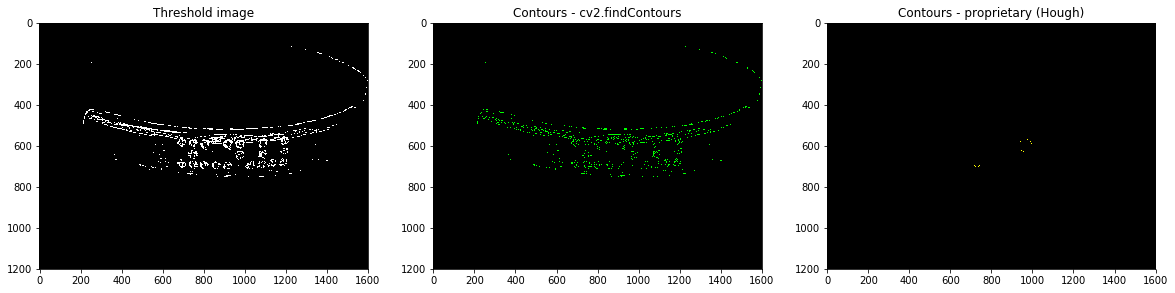

In [72]:
# Find all contours in the image:
contours_orig, _ = cv2.findContours(frame_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Create contours image:
frame_contours1 = np.zeros((height, width, 3), np.uint8)
frame_contours2 = np.zeros((height, width, 3), np.uint8)
cv2.drawContours(frame_contours1, contours_orig, -1, Colors.green);
cv2.drawContours(frame_contours2, contours, -1, Colors.yellow);

fig, ax = plt.subplots(1,3, figsize=(20,16))
ax[0].imshow(frame_thresh, cmap='gray')
ax[1].imshow(frame_contours1)
ax[2].imshow(frame_contours2)
ax[0].set_title('Threshold image')
ax[1].set_title('Contours - cv2.findContours')
ax[2].set_title('Contours - proprietary (Hough)')
plt.show()

<hr>